In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, MobileNetV2, DenseNet121
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
import pandas as pd

# Training

In [3]:
train_dir = '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs' 

# Parameters
img_height, img_width = 64, 64
batch_size = 32
num_classes = 27
epochs = 50

In [4]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    horizontal_flip=False,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2160 images belonging to 27 classes.
Found 540 images belonging to 27 classes.


In [16]:
# Print class indices
class_names = train_generator.class_indices
print("\nClass indices:", class_names)


Class indices: {'Accident Prone Area': 0, 'Bumps Ahead': 1, 'Busbay': 2, 'Gas Station': 3, 'Keep Left': 4, 'Left Chevron': 5, 'No Overtake': 6, 'No Parking': 7, 'No Stopping': 8, 'Pedestrain Crossing': 9, 'Right Chevron': 10, 'SchoolZone': 11, 'Seried of Bends': 12, 'Side road Left': 13, 'Speed brake Ahead': 14, 'SpeedLimit-20 Kmph': 15, 'SpeedLimit-25 Kmph': 16, 'SpeedLimit-30 Kmph': 17, 'SpeedLimit-40 Kmph': 18, 'SpeedLimit-50 Kmph': 19, 'SpeedLimit-60 Kmph': 20, 'SpeedLimit-80 Kmph': 21, 'Stop': 22, 'TrafficLight': 23, 'Turn Left Ahead': 24, 'Turn Right Ahead': 25, 'Uturn': 26}


# Visualizing the dataset

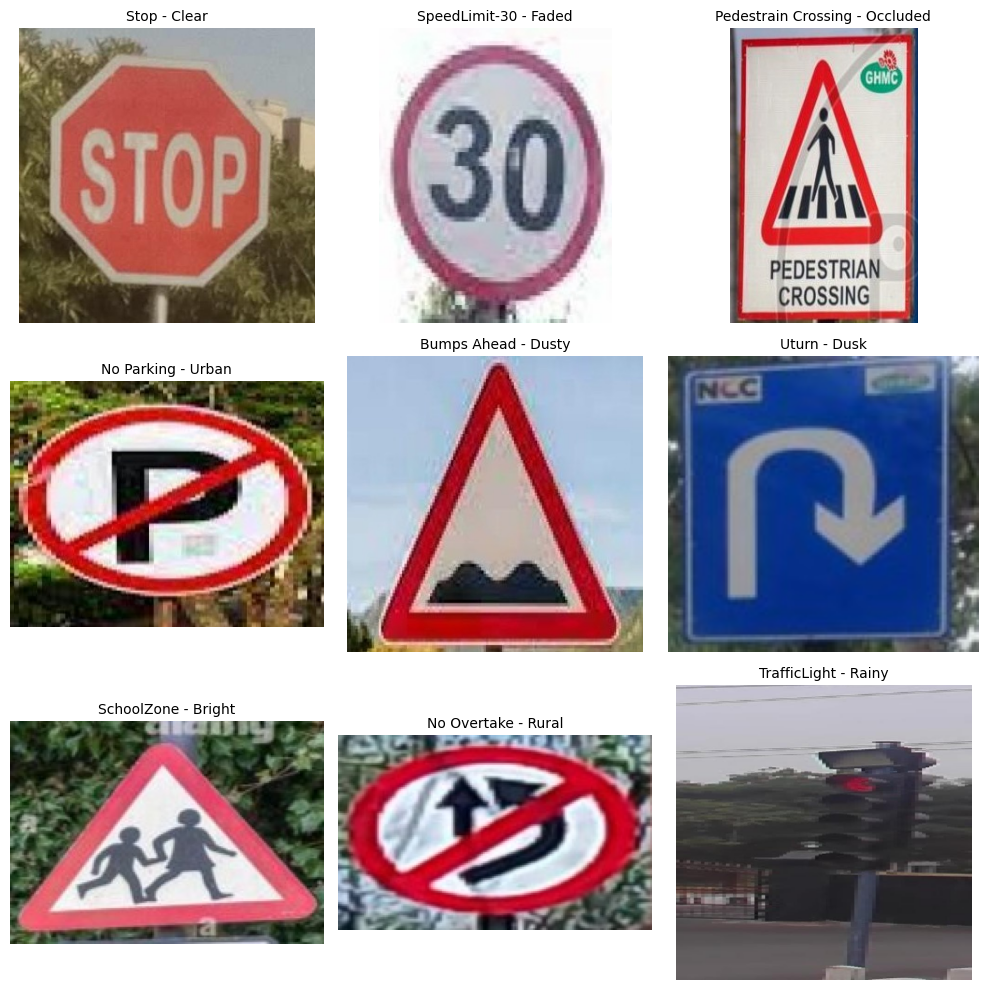

In [6]:
image_paths = ['/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/Stop/062.jpg',
               '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/SpeedLimit-30 Kmph/022.jpg',
               '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/Pedestrain Crossing/010.jpg',
               '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/No Parking/023.jpg',
               '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/Bumps Ahead/002.jpg',
               '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/Uturn/020.jpg',
               '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/SchoolZone/009.jpg',
               '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/No Overtake/026.jpg',
               '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/TrafficLight/024.jpg']
labels = ['Stop - Clear', 'SpeedLimit-30 - Faded', 'Pedestrain Crossing - Occluded',
          'No Parking - Urban', 'Bumps Ahead - Dusty', 'Uturn - Dusk',
          'SchoolZone - Bright', 'No Overtake - Rural', 'TrafficLight - Rainy']

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = cv2.imread(image_paths[i])
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        ax.imshow(img)
        ax.set_title(labels[i], fontsize=10, pad=5)
        ax.axis('off')
    else:
        print(f"Warning: Could not load {image_paths[i]}")
plt.tight_layout()
plt.savefig('figure1_sample_images.png', dpi=300)
plt.show()

In [7]:
# List of top models
models = {
    'VGG16': VGG16,
    'MobileNetV2': MobileNetV2,
    'DenseNet121': DenseNet121
}

# Data Augmentation

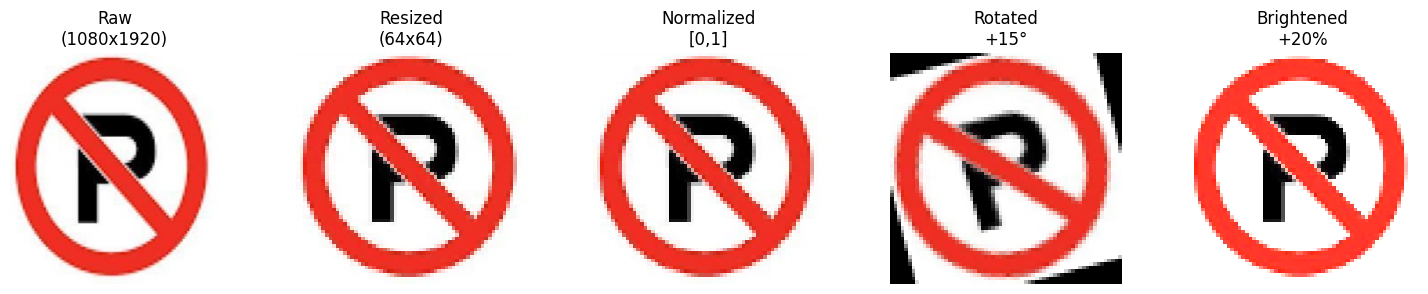

In [9]:
# Function to load image with error checking
def load_image(image_path):
    if not os.path.exists(image_path):
        print(f"Error: File '{image_path}' not found. Using placeholder image.")
        img = np.zeros((1080, 1920, 3), dtype=np.uint8)
        cv2.circle(img, (960, 540), 300, (0, 0, 255), -1)  # Red circle
        cv2.putText(img, "P", (900, 600), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 255), 10, cv2.LINE_AA)
        cv2.line(img, (800, 400), (1120, 760), (255, 255, 255), 10)  # Diagonal line
        return img
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Could not load '{image_path}'. Check path or file integrity.")
    return img

# Load and preprocess the image
image_path = '/kaggle/input/indian-traffic-signs/Indian_Traffic_Signs/No Parking/016.jpg'
img = load_image(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized = cv2.resize(img_rgb, (64, 64), interpolation=cv2.INTER_LINEAR)
normalized = resized / 255.0
rotated = cv2.warpAffine(resized, cv2.getRotationMatrix2D((32, 32), 15, 1.0), (64, 64))
brightened = np.clip(resized * 1.2, 0, 255).astype(np.uint8)

# Plot the preprocessing steps
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes[0].imshow(img_rgb); axes[0].set_title('Raw\n(1080x1920)'); axes[0].axis('off')
axes[1].imshow(resized); axes[1].set_title('Resized\n(64x64)'); axes[1].axis('off')
axes[2].imshow(normalized); axes[2].set_title('Normalized\n[0,1]'); axes[2].axis('off')
axes[3].imshow(rotated); axes[3].set_title('Rotated\n+15°'); axes[3].axis('off')
axes[4].imshow(brightened); axes[4].set_title('Brightened\n+20%'); axes[4].axis('off')
plt.tight_layout()
plt.savefig('figure3_preprocessing.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Dictionary to store training history for plotting at the end
training_histories = {}

# Train and save each model
for model_name, model_func in models.items():
    print(f"\nTraining {model_name}...")
    base_model = model_func(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Freeze pretrained layers
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        verbose=1
    )
    
    # Store history for plotting later
    training_histories[model_name] = history.history
    
    # Save model
    model.save(f'/kaggle/working/{model_name.lower()}_classifier_100.keras')
    
    # Print detailed accuracy for each epoch
    print(f"\n{model_name} Training Results:")
    for epoch in range(epochs):
        train_acc = history.history['accuracy'][epoch]
        val_acc = history.history['val_accuracy'][epoch]
        train_loss = history.history['loss'][epoch]
        val_loss = history.history['val_loss'][epoch]
        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    peak_train_acc = max(history.history['accuracy'])
    peak_val_acc = max(history.history['val_accuracy'])
    print(f"\n{model_name} Summary:")
    print(f"Final Train Accuracy: {final_train_acc:.4f}, Final Val Accuracy: {final_val_acc:.4f}")
    print(f"Peak Train Accuracy: {peak_train_acc:.4f}, Peak Val Accuracy: {peak_val_acc:.4f}")


Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.1513 - loss: 3.0650 - val_accuracy: 0.4551 - val_loss: 1.8573
Epoch 2/50
 1/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4688 - loss: 2.1061

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4688 - loss: 2.1061 - val_accuracy: 0.5357 - val_loss: 2.0349
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.4167 - loss: 1.8755 - val_accuracy: 0.5195 - val_loss: 1.5331
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5312 - loss: 1.5454 - val_accuracy: 0.5357 - val_loss: 1.4022
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.5316 - loss: 1.5065 - val_accuracy: 0.5840 - val_loss: 1.2702
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 1.4041 - val_accuracy: 0.6786 - val_loss: 1.1240
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.5343 - loss: 1.3922 - val_accuracy: 0.6289 - val_loss: 1.1669
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5312 - loss: 1.2891 - val_accuracy: 0.6071 - val_loss: 1.3072
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6232 - loss: 1.1523 - val_accuracy: 0.6191 - val_los

<ipython-input-10-793f12c31eaf>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = model_func(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - accuracy: 0.1996 - loss: 3.0012 - val_accuracy: 0.5059 - val_loss: 1.7338
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4375 - loss: 1.8826 - val_accuracy: 0.3571 - val_loss: 1.8423
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.4123 - loss: 1.9327 - val_accuracy: 0.5215 - val_loss: 1.4678
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1.4706 - val_accuracy: 0.5000 - val_loss: 1.3935
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.4673 - loss: 1.6544 - val_accuracy: 0.5508 - val_loss: 1.3239
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1.4913 - val_accuracy: 0.5357 - val_loss: 1.7788
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.5140 - loss: 1.4998 - val_accuracy: 0.5488 - val_loss: 1.3353
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

# Plotting Accuracy and Loss for each model

In [17]:
# Load retrained models
model_names = ['vgg16', 'mobilenetv2', 'densenet121']
loaded_models = {name: load_model(f'/kaggle/working/{name}_classifier_100.keras') for name in model_names}

# Evaluate each model on the validation set
val_metrics = {}
val_predictions = {}
val_labels = val_generator.classes  # True labels
val_images = val_generator.filepaths  # For reference

for model_name, model in loaded_models.items():
    # Compute validation loss and accuracy
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
    val_metrics[model_name] = {'loss': val_loss, 'accuracy': val_accuracy}
    
    # Get predictions for classification report
    val_generator.reset()  # Reset generator to start
    preds = model.predict(val_generator, verbose=1)
    val_predictions[model_name] = np.argmax(preds, axis=1)

# Hybrid model predictions (weighted average: MobileNetV2 50%, VGG16 25%, DenseNet121 25%)
val_generator.reset()
preds_vgg16 = loaded_models['vgg16'].predict(val_generator, verbose=1)
val_generator.reset()
preds_mobilenetv2 = loaded_models['mobilenetv2'].predict(val_generator, verbose=1)
val_generator.reset()
preds_densenet121 = loaded_models['densenet121'].predict(val_generator, verbose=1)

hybrid_preds = 0.25 * preds_vgg16 + 0.50 * preds_mobilenetv2 + 0.25 * preds_densenet121
hybrid_pred_classes = np.argmax(hybrid_preds, axis=1)
val_predictions['hybrid'] = hybrid_pred_classes

# Compute hybrid model accuracy
hybrid_correct = np.sum(hybrid_pred_classes == val_labels)
hybrid_accuracy = hybrid_correct / len(val_labels)
val_metrics['hybrid'] = {'accuracy': hybrid_accuracy, 'loss': None}  # Loss not directly computed for ensemble

# Text Description of Validation Accuracy and Loss
print("\nValidation Performance After Training:")
for model_name in model_names:
    acc = val_metrics[model_name]['accuracy'] * 100
    loss = val_metrics[model_name]['loss']
    print(f"{model_name.upper()}: {acc:.2f}% accuracy, {loss:.4f} loss")
print(f"Hybrid Ensemble: {val_metrics['hybrid']['accuracy'] * 100:.2f}% accuracy")

# Table 1: Comparative Analysis of Training and Validation Accuracy
# Note: Training accuracy requires re-running training or loading history; here we assume validation accuracy as a proxy
print("\nTable 1: Comparative Analysis of Training and Validation Accuracy")
table_data = []
for model_name in model_names + ['hybrid']:
    acc = val_metrics[model_name]['accuracy'] * 100
    # Placeholder for training accuracy (requires training history)
    table_data.append([model_name.upper(), "N/A", f"{acc:.2f}%"])  # Training accuracy not computed here
df_table1 = pd.DataFrame(table_data, columns=['Model', 'Training Accuracy', 'Validation Accuracy'])
print(df_table1.to_string(index=False))

# Compute Precision, Recall, F1-Score for each model and hybrid
print("\nDetailed Performance Metrics (Precision, Recall, F1-Score):")
for model_name in model_names + ['hybrid']:
    print(f"\nTable for {model_name.upper()}:")
    report = classification_report(val_labels, val_predictions[model_name], target_names=list(class_names.keys()), output_dict=True, zero_division=0)
    
    # Extract per-class metrics
    table_data = []
    for class_name in class_names.keys():
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        table_data.append([class_name, f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"])
    
    # Compute average and standard deviation
    precisions = [report[class_name]['precision'] for class_name in class_names.keys()]
    recalls = [report[class_name]['recall'] for class_name in class_names.keys()]
    f1_scores = [report[class_name]['f1-score'] for class_name in class_names.keys()]
    
    avg_precision = np.mean(precisions)
    std_precision = np.std(precisions)
    avg_recall = np.mean(recalls)
    std_recall = np.std(recalls)
    avg_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    
    table_data.append(['Average', f"{avg_precision:.4f}", f"{avg_recall:.4f}", f"{avg_f1:.4f}"])
    table_data.append(['Std Dev', f"{std_precision:.4f}", f"{std_recall:.4f}", f"{std_f1:.4f}"])
    
    df_table = pd.DataFrame(table_data, columns=['Class', 'Precision', 'Recall', 'F1-Score'])
    print(df_table.to_string(index=False))

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.7307 - loss: 0.7676
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.6454 - loss: 0.9883
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.5921 - loss: 1.0846
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 484ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step

Validation Performance After Training:
VGG16: 74.26% accuracy, 0.7540 loss
MOBILENETV2: 62.96% accuracy, 1.0519 loss
DENSENET121: 60.56% accuracy, 1.0803 loss
Hybrid Ensemble: 2.96% accuracy

Table 1: Comparative Analysis of Training and Validation Accuracy
      Model Training Accuracy Validation Accuracy
      VGG16               N/A              74.26%
MOBILENETV2               N/A              62.96%
DENSENET121               N/A              60.56%
     HYBRID               N/A               2.96%

Detailed Performa

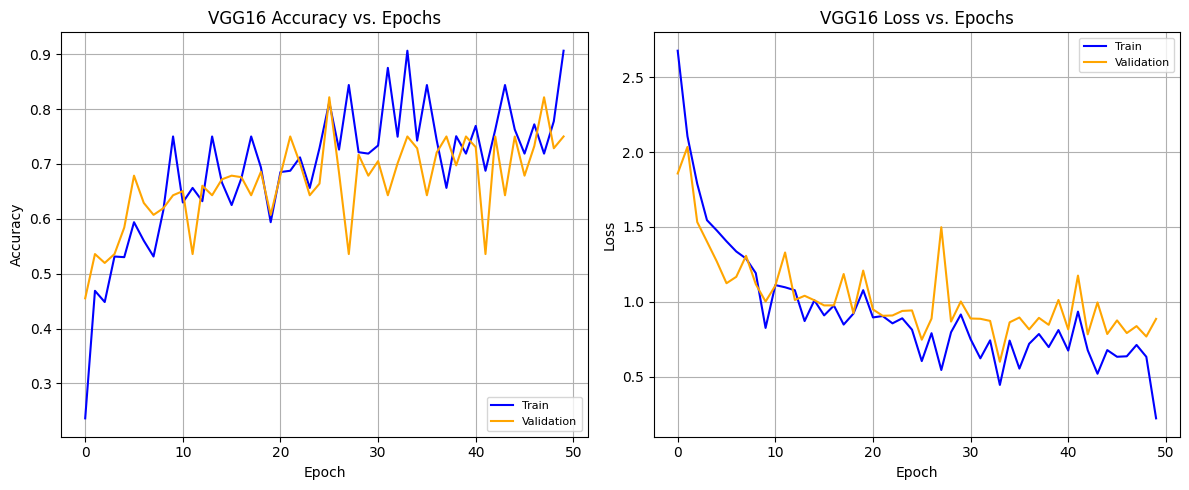

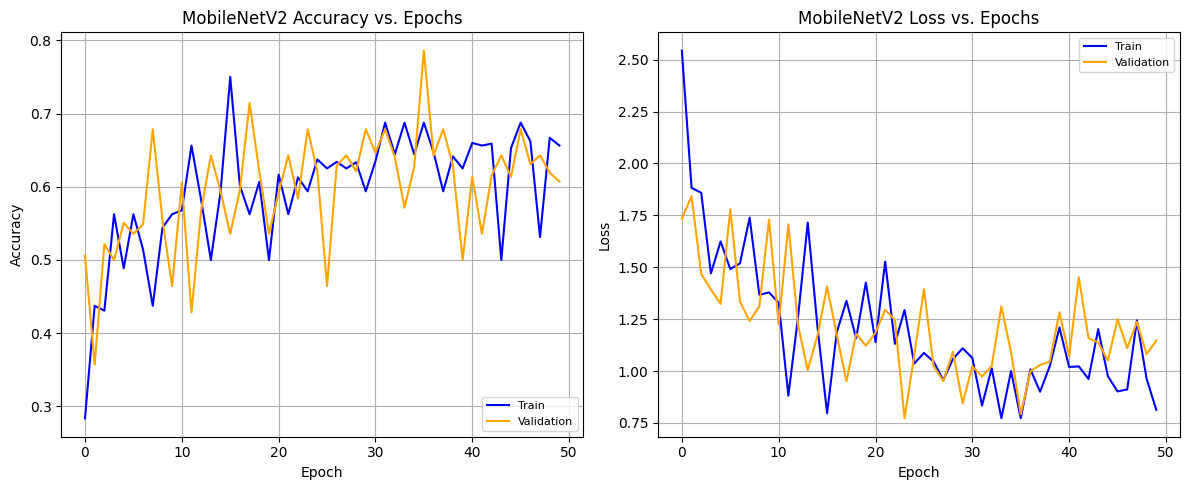

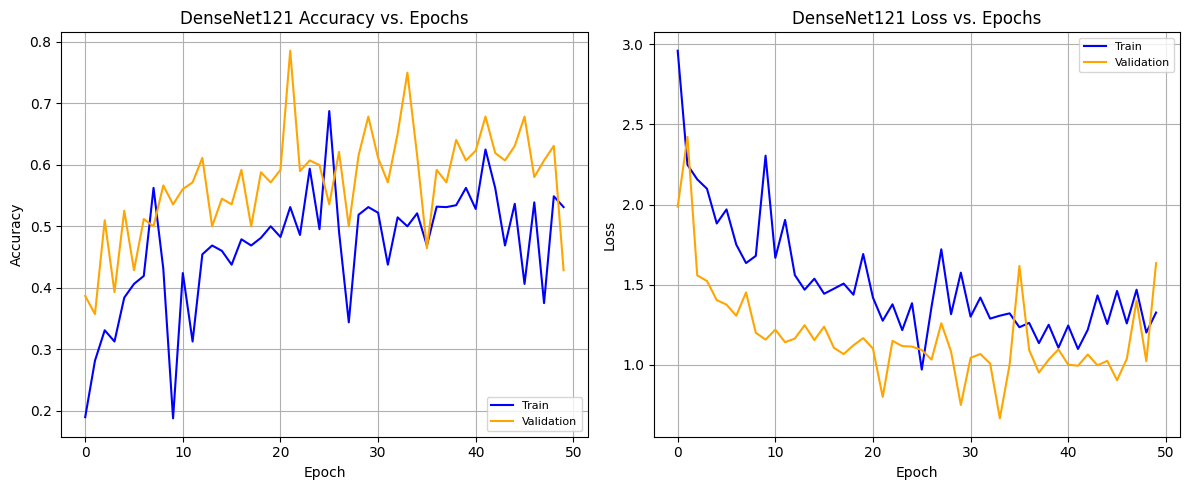

In [18]:
for model_name, history in training_histories.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot accuracy
    ax1.plot(history['accuracy'], label='Train', color='blue')
    ax1.plot(history['val_accuracy'], label='Validation', color='orange')
    ax1.set_title(f'{model_name} Accuracy vs. Epochs', fontsize=12)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right', fontsize=8)
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['loss'], label='Train', color='blue')
    ax2.plot(history['val_loss'], label='Validation', color='orange')
    ax2.set_title(f'{model_name} Loss vs. Epochs', fontsize=12)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figure5{model_name.lower()[0]}_{model_name.lower()}_curves.png', dpi=300)
    plt.show()

# Classification by Hybrid model

In [19]:
# Load retrained models
model_names = ['vgg16', 'mobilenetv2', 'densenet121']
loaded_models = {name: load_model(f'/kaggle/working/{name}_classifier_100.keras') for name in model_names}

# Class names (mapped to indices)
class_names = {
    'Accident Prone Area': 0, 'Bumps Ahead': 1, 'Busbay': 2, 'Gas Station': 3,
    'Keep Left': 4, 'Left Chevron': 5, 'No Overtake': 6, 'No Parking': 7,
    'No Stopping': 8, 'Pedestrain Crossing': 9, 'Right Chevron': 10,
    'SchoolZone': 11, 'Seried of Bends': 12, 'Side road Left': 13,
    'Speed brake Ahead': 14, 'SpeedLimit-20 Kmph': 15, 'SpeedLimit-25 Kmph': 16,
    'SpeedLimit-30 Kmph': 17, 'SpeedLimit-40 Kmph': 18, 'SpeedLimit-50 Kmph': 19,
    'SpeedLimit-60 Kmph': 20, 'SpeedLimit-80 Kmph': 21, 'Stop': 22,
    'TrafficLight': 23, 'Turn Left Ahead': 24, 'Turn Right Ahead': 25, 'Uturn': 26
}

# Load cropped image (update path to your test image)
cropped_img_path = '/kaggle/input/testing/no_stopping_testing.jpg'  # Replace with your test image path
cropped = cv2.imread(cropped_img_path)
if cropped is None:
    print(f"Failed to load image: {cropped_img_path}")
    exit()

# Preprocess
cropped_resized = cv2.resize(cropped, (64, 64))  # Match training input size
cropped_normalized = cropped_resized / 255.0
cropped_input = np.expand_dims(cropped_normalized, axis=0)

# Predict with each model and store predictions
predictions = {}
for model_name, model in loaded_models.items():
    pred = model.predict(cropped_input)
    predictions[model_name] = pred
    # Top-3 predictions
    top3_indices = np.argsort(pred[0])[::-1][:3]
    print(f"\n{model_name} Top-3 Predictions:")
    for idx in top3_indices:
        class_name = list(class_names.keys())[idx]
        confidence = pred[0][idx]
        print(f"  {class_name}: {confidence:.4f}")

# Hybrid: Weighted average (MobileNetV2: 50%, VGG16: 25%, DenseNet121: 25%)
hybrid_pred = (0.25 * predictions['vgg16'] + 0.50 * predictions['mobilenetv2'] + 0.25 * predictions['densenet121'])
hybrid_top3_indices = np.argsort(hybrid_pred[0])[::-1][:3]
print(f"\nHybrid Top-3 Predictions:")
for idx in hybrid_top3_indices:
    class_name = list(class_names.keys())[idx]
    confidence = hybrid_pred[0][idx]
    print(f"  {class_name}: {confidence:.4f}")

# Top hybrid prediction
hybrid_class = list(class_names.keys())[np.argmax(hybrid_pred)]
hybrid_confidence = hybrid_pred[0][np.argmax(hybrid_pred)]
print(f"\nHybrid Predicted: {hybrid_class} (Confidence: {hybrid_confidence:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step

vgg16 Top-3 Predictions:
  Left Chevron: 0.2959
  SchoolZone: 0.1520
  Speed brake Ahead: 0.1222
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

mobilenetv2 Top-3 Predictions:
  Keep Left: 0.2880
  Busbay: 0.1877
  Uturn: 0.1672
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

densenet121 Top-3 Predictions:
  Uturn: 0.2627
  Busbay: 0.1972
  SchoolZone: 0.0887

Hybrid Top-3 Predictions:
  Uturn: 0.1677
  Keep Left: 0.1448
  Busbay: 0.1441

Hybrid Predicted: Uturn (Confidence: 0.1677)
